In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import math as mt
from scipy.misc import derivative as dv

# Интерполяция многочленами

Допустим мы знаем значения $f_k=f(x_k)$ некоторой функции $f(x)$ только на некотором множестве аргументов $x_k\in\mathbb R$, $k=1..K$.
Мы хотим вычислять $f$ в точках $x$ лежащих между узлами интерполяции $x_k$, для чего мы строим интерполирующую функцию $p(x)$, определенную при всех значениях $x$ и совпадающую с $f$ в узлах интерполяции $f(x)=p(x)$, $k=1..K$.
Распространенным (но не единственным) выбором для функции $p$ является многочлен степени $K-1$:

$$p(x)=\sum_{n=0}^{K-1} p_n x^n,$$

число коэффициентов которого равно число известных значений функции, что позволяет однозначно найти эти коэффициенты.
Формально коэффициенты находятся из системы уравнений:

$$p(x_k)=f_k=\sum_{n=0}^{K-1} p_n x_k^n,$$

или в матричном виде $MP=F$, где 

$$
F=\begin{pmatrix}f_1\\\vdots\\f_K\end{pmatrix},\quad
P=\begin{pmatrix}p_0\\\vdots\\p_{K-1}\end{pmatrix},\quad
M=\begin{pmatrix}
x_1^0 & \cdots & x_1^{K-1} \\
\vdots & \ddots & \vdots \\
x_K^0 & \cdots & x_K^{K-1} \\
\end{pmatrix}.
$$
Матрица $M$ называется [матрицей Вандермонда](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B8%D1%82%D0%B5%D0%BB%D1%8C_%D0%92%D0%B0%D0%BD%D0%B4%D0%B5%D1%80%D0%BC%D0%BE%D0%BD%D0%B4%D0%B0).
Попробуем построить интерполяционный многочлен таким способом.

In [4]:
# Numpy уже имеет класс для полиномов: numpy.poly1d.
# Для полноты изложения мы реализуем свой класс.
class Poly():
    def __init__(self, pn):
        """
        Создает многочлен с коэффициентами pn:
            self(x) = sum_n pn[n] * x**n.
        Коэффициенты pn перечисляются в порядке возрастания степени одночлена.
        """
        self.pn = pn
    def __call__(self, x):
        """
        Вычисляет многочлен на векторе значений x.
        """
        a = 1. # Здесь мы накапливаем степени x**n.
        p = 0. # Сюда мы помещаем сумму одночленов.
        for pn in self.pn:
            p += a*pn # Учитываем очередной одночлен.
            a *= x # Повышаем степень одночлена
        return p
    
# Вспомогательная функция для счета матрицы Вандермонда.
def vandermonde(xn):
    return np.power(xn[:,None], np.arange(len(xn))[None,:])

# Напишем функцию, которая будет находить интерполяционных многочлен через решение системы.
def interp_naive(xn, fn):
    """
    Возвращает интерполяционный многочлен, принимающий в точках xp значение fp.
    """
    M = vandermonde(xn)
    # Мы используем функцию numpy для решения линейных систем. 
    # Методы решения линейных систем обсуждаются в другой лабораторной работе.
    pn = np.linalg.solve(M, fn)
    return Poly(pn)

# Возьмем логарифмическую решетку на интервале [1E-6,1] и посмотрим, насколько точно мы восстанавливаем многочлен.
N = 8 # Число узлов интерполяции.
x = np.logspace(-6,0,N) # Точки равномерной решетки
# Будет интерполировать многочлен степени N-1, который зададим случайными коэффициентами.
f = Poly(np.random.randn(N))
y = f(x) # Значения многочлена на решетке.
p = interp_naive(x, y) # Строим интерполяционный многочлен.
z = p(x) # Значения интерполяционного многочлена на решетке.
print("Absolute error of values", np.linalg.norm(z-y))
print("Absolute error of coefficients", np.linalg.norm(f.pn-p.pn))

Absolute error of values 3.3893637946200144e-15
Absolute error of coefficients 429.07308485578534


Построенный интерполяционный многочлен принимает близкие значения к заданным в узлах значениям.
Но хотя значения в узлах должны задавать многочлен однозначно, интерполяционный и интерполируемый многочлен имеют значительно отличающиеся коэффициенты. Значения многочленов между узлами также значительно отличаются.

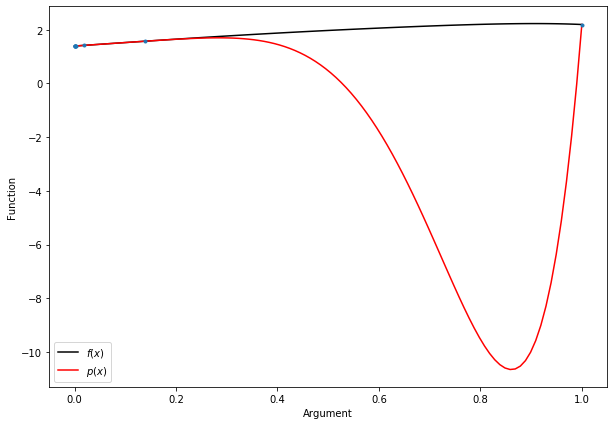

In [5]:
t = np.linspace(0,1,100)
_, ax = plt.subplots(figsize=(10,7))
ax.plot(t, f(t), '-k')
ax.plot(t, p(t), '-r')
ax.plot(x, f(x), '.')
ax.set_xlabel("Argument")
ax.set_ylabel("Function")
ax.legend(["$f(x)$", "$p(x)$"])
plt.show()

## Задания

1. Измените метод `__call__`, так чтобы он реализовывал [схему Горнера](https://ru.wikipedia.org/wiki/Схема_Горнера). Чем эта схема лучше?
2. Почему нахождение коэффициентов интерполяционного многочлена через решение системы дает ошибочный ответ? 
3. Найдите определитель матрицы Вандермонда теоретически и численно. 
4. Найдите числа обусловленности матрицы Вандермонда. Сравните экспериментально полученные погрешности решения системы и невязку с теоретическим предсказанием.

# Решение

$\textbf{Задание 1.}$ Погрешность вычисления будет меньше из-за того, что мы делаем меньше операций сложения и умножения.

In [6]:
class Poly2():
    def __init2__(self, pn):
        self.pn = pn
        
    def __call2__(self, x):
        """
        Через Горнера
        """
        acc=self.pn[-1]
        for i in range(len(self.pn)):
            acc=acc*x+self.pn[-i-1]
        return acc

$\textbf{Задание 2.}$ При решении системы могут возникнуть проблемы: при большом числе обусловленности матрицы решение может и не сойтись. Тогда полученное решение может не соответствовать действительности.

$\textbf{Задание 3.}$ Определитель матрицы Вандермонда равен $det W=\prod \limits_{1\le i<j \le n} (x_i-x_j)$ (мы его считали на линейной алгебре в 1 семестре). Численно его можно посчитать с помощью встроенной функции det() из пакета linalg NumPy.

In [7]:
def detW(A):
    p=1
    for j in range(0,np.shape(A)[1]):
        for i in range(j+1,np.shape(A)[1]):
            d=A[i,1]-A[j,1]
            p=p*d
    return(p)

In [8]:
M=vandermonde(x)
print(np.linalg.det(M))
print(detW(M))

3.0753158985971445e-49
3.074989474009368e-49


$\textbf{Задание 4.}$ Число обусловленности матрицы считается по формуле: $\kappa(A)=\|A\|\|A^{-1}\|$, где норма матрицы может быть любой. А значит, числа обусловленности будут разными. Однако число обусловленности через спектральною меру имеет наименьшее значение среди всех остальных норм. Также норма матрицы всегда больше 1. Норму можно посчитать с помощью встроенной функции linalg.norm. А можно воспользоваться linalg.cond, чтобы сразу посчитать числа обусловленности. Интерполяционные многочлены точны в узлах интерполяции, в других точках - значения могут сильно отличаться.

In [9]:
np.linalg.cond(M)

2.6245217742490032e+17

Найдем теор.погрешность для системы $M \cdot P = F$; $F=F+\Delta F; \; M \cdot (P+\Delta P)=F+\Delta F$

$$\frac{||\Delta P||}{||P||} \bigg/ \frac{||\Delta F||}{||F||} = \frac{||\Delta P|| \cdot ||F||}{||\Delta F|| \cdot ||P||}$$

$$F = M \cdot P; \; ||F||\leq ||M|| \cdot ||P|| $$

$$\Delta P = M^{-1} \Delta F; \; ||\Delta P||\leq ||M^{-1}|| \cdot ||\Delta F|| $$

$$\frac{||\Delta P||}{||P||} \bigg/ \frac{||\Delta F||}{||F||} \leq \frac{||M^{-1}|| \cdot ||\Delta F|| \cdot ||M|| \cdot ||P||}{||\Delta F|| \cdot ||P||} = \kappa(M)$$

$$||\Delta P|| \leq \kappa(M) \cdot \frac{||\Delta F||}{||F||} \cdot ||P||$$

In [10]:
eps=np.finfo(np.double).eps
np.linalg.cond(M)*np.linalg.norm(f.pn*eps)/np.linalg.norm(f.pn)*np.linalg.norm(p.pn)

25004.18654752849

Реальная погрешность:

In [12]:
np.linalg.norm(p.pn-f.pn)

429.07308485578534

На практике интерполяционный многочлен обычно находится в форме [многочлена Лагранжа](https://ru.wikipedia.org/wiki/Интерполяционный_многочлен_Лагранжа):

$$
p(x)=\sum_{k=1}^K f_k L_k(x),\;\text{где}\;
L_k(x)=\prod_{j\neq k}\frac{x-x_j}{x_k-x_j}.
$$

Для ускорения вычисления многочлена Лагранжа используется [схема Эйткена](https://ru.wikipedia.org/wiki/Схема_Эйткена), основанная на рекурсии. Обозначим $p_{i,\ldots,j}$ многочлен Лагранжа, построенный по узлам интерполяции $(x_i,f_i),\ldots,(x_j,f_j)$,
в частности искомое $p=p_{1,\ldots,K}$. Справедливо следующее соотношение, выражающие интеполяционный многочлен через такой же с меньшим числом узлов:

$$
p_{i,\ldots,j}=\frac{(x-x_i)p_{i+1,\ldots,j}-(x-x_j)p_{i,\ldots,j-1}(x)}{x_j-x_i}.
$$

База рекурсии задается очевидным равенством $p_{i}(x)=f_i$.

[Интерполяционные формулы Ньютона](ru.wikipedia.org/wiki/Интерполяционные_формулы_Ньютона) дают другой популярный способ записи интерполяционного многочлена:

$$
p(x)=\sum_{k=1}^K[x_1,\ldots,x_k]f\prod_{i=1}^k(x-x_j),
$$

где разделенные разности $[\ldots]f$ заданы рекурсивно:

$$
[x_1,\ldots,x_k,x]f=\frac{[x_1,\ldots,x_{k-1},x]f-[x_1,\ldots,x_{k-1},x_k]f}{x-x_k}.
$$

Данные формулы можно рассматривать как дискретный вариант формулы Тейлора. 
На основе формул Ньютона разработан [алгоритм Невилла](https://en.wikipedia.org/wiki/Neville%27s_algorithm) для вычисления интерполяционного многочлена, по существу эквивалентный схеме Эйткена.

## Задания

5. Реализуйте метод Эйткена вычисления интерполяционного многочлена.  
6. Если мы попытаемся восстановить многочлен через его значения в точках, аналогично заданию 2, получим ли мы с помощью метода Эйткена ответ точнее, чем через решение системы?
7. Scipy содержит готовую реализацию интерполяционного многочлена Лагранжа [`scipy.interpolate.lagrange`](docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.lagrange.html). В документации отмечается, что метод численно неустойчив. Что это означает?
8. Ошибки в исходных данных для построения интерполяционного многочлена вызывают ошибки при вычислении интерполяционного многочлена в промежуточных точках. При каком расположении узлов интерполяция многочленом Лагранжа имеет наименьшую ошибку? Как это связано с численной устойчивостью? 

# Решение

$\textbf{Задание 5.}$ Методом рекурсии находим интерполяционный многочлен.

In [37]:
def p_a(x,i,j,xn,yn):
    if i==j:
        return yn[i]  
    p=((x-xn[i])*p_a(x,i+1,j,xn,yn)-(x-xn[j])*p_a(x,i,j-1,xn,yn))/(xn[j]-xn[i])
    return p

def Aitken(x, xn, yn):
    N=len(xn)
    return p_a(x,0,N-1,xn,yn)

$\textbf{Задание 6.}$ Точность сильно не может измениться, так как приблежение осуществляется с помощью полиномов. Отклонения между узлами интерполяции вызваны из-за метода итераций. 

Absolute error of values 2.8609792490763984e-17


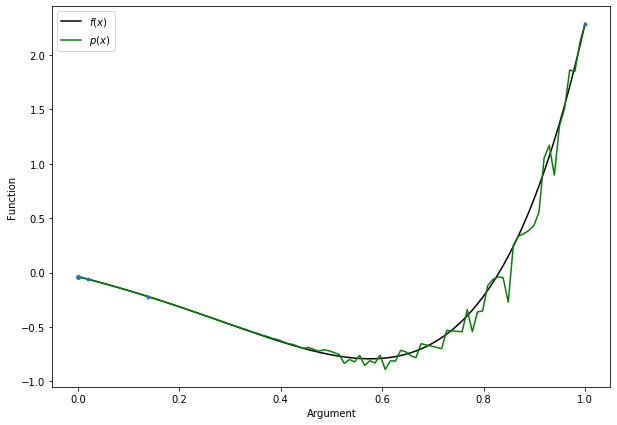

In [43]:
N=8 # Число узлов интерполяции.
x=np.logspace(-6,0,N) # Точки равномерной решетки
f=Poly(np.random.randn(N))
y=f(x) # Значения многочлена на решетке.
z=Aitken(x,x,y) # Значения интерполяционного многочлена на решетке.
print("Absolute error of values", np.linalg.norm(z-y))

t=np.linspace(0,1,100)
_, ax=plt.subplots(figsize=(10,7))
ax.plot(t, f(t), '-k')
ax.plot(t, Aitken(t,x,y), '-g')
ax.plot(x, f(x), '.')
ax.set_xlabel("Argument")
ax.set_ylabel("Function")
ax.legend(["$f(x)$", "$p(x)$"])
plt.show()

$\textbf{Задание 7.}$ Алгоритм численно неустойчив, если незначительные изменения входных данных вносят весомый вклад в ошибки на выходе работы метода. 

$\textbf{Задание 8.}$ Для итерационных методов погрешность возмущения считается примерно так: $|\Delta p(x)|\leq \varepsilon \Lambda_N$, где $\Lambda_N$ - константа Лебега. Для разных методов она разная: если узлы интерполяции распределены $\textbf{равномерно}$, то $\Lambda_N \approx \cfrac{2^N}{N log N}; \;$ для $\textbf{Чебышевских}$ узлов на интервале $[-1;1]: \Lambda_N \leq 1 + \cfrac 2 \pi log N $.

Чебышевские узлы являются оптимальными и уменьшают увеличение погрешности.

Рассмотрим теперь насколько хорошо интерполяционный многочлен  прилижает интерполируемую функцию. 

Error 0.21298615938147591


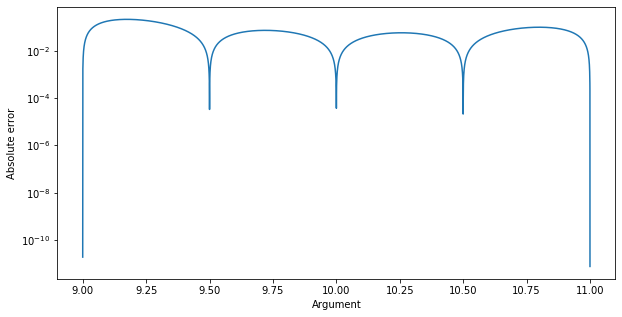

In [50]:
# В качестве интерполируемой функции возьмем f(x)=x sin(2x.
def f(x):
    return x*np.sin(2*x)

# Будем интерполировать функцию на интервале [x0-r,x0+r], где
x0 = 10
r = 1

# В качестве узлов интерполяции возьмем равномерную решетку из N узлов.
N = 5
xn = np.linspace(x0-r, x0+r, N)

# Построим интерполяционный многочлен.
p = interp_naive(xn, f(xn))
                 
# Оценим точность приближения функции многочленом как максимум 
# отклонения значений многочлена от значений функции на интервале.
# Так как мы не можем рассмотреть все точки, то ограничимся 
# плотной решеткой.
tn = np.linspace(x0-r, x0+r, 10000)
error = np.abs(f(tn)-p(tn))
print("Error", np.max(error))

_, ax = plt.subplots(figsize=(10,5))
ax.semilogy(tn, error)
ax.set_xlabel("Argument")
ax.set_ylabel("Absolute error")
plt.show()

# Задания

9. Найдите погрешность прилижения функции $f$ интерполяционным многолченом $p$ для $x0=10, 100, 1000$ и для $N=5, 10, 15$. Объясните получающиеся результаты.

10. Постройте график зависимости ошибки от числа узлов интерполяции $N$ для $x0=100$ и $r=5$ в диапазоне  $5\leq N \leq 50$. 

11. Повторите задания 9 и 10 для узлов интерполяции Чебышева:

$$x_n=x0+r\cos\left(\frac{\pi}{2}\frac{2n-1}{N}\right),\; k=1\ldots N.$$

12. Сравните распределение ошибки внутри интервала $x\in[x0-r,x0+r]$ для равномерно расположенных узлов и для узлов Чебышева.

13. Повторите задания 9 и 10 для функции $f(x)=|x-1|$, $x0=1$, $r=1$. Объясните наблюдающиеся различия.

Использование интерполяционного полинома очень высокой степени часто приводит к тому, что в некоторых точках погрешность приближения оказывается очень большой.
Вместо одного многочлена высокой степени, приближающего функцию на всем интервале, можно использовать несколько многочленов меньше степени, каждый из которых приближает функцию только на подинтервале. 
Если функция обладает некоторой степенью гладкости, например, несколько ее производных непрерывные функции, то такую же гладкость естественно требовать от результирующего семейства интерполяционных многочленов, что накладывает ограничения на их коэффициенты.
Получающаяся кусочно-полиномиальная функция называется [сплайном](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD). [Кубическим сплайном](https://ru.wikipedia.org/wiki/%D0%9A%D1%83%D0%B1%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D1%81%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD) дефекта 1 называется функция, которая:

1. на каждом интервале $[x_{k-1}, x_k]$ является многочленом третьей степени (или меньше);
2. имеет непрерывные первую и вторую производные во всех точках;
3. совпадает с интерполируемой функцией в узлах $x_k$.

# Решение

$\textbf{Задание 9.}$ Теоретически погрешность можно оценить с помощью формулы: $|f(x)-p_N(x)|\leq \max \limits_{\xi \in [a;b]} \left[ \cfrac{\left|f^{(N+1)}(\xi(x))\right|}{(N+1)!}\, \left|\mathcal{N}_{N+1}(x)\right|  \right], \mathcal{N}_{N+1}(x)=(x-x_0)\cdot(x-x_1)\cdot...\cdot(x-x_N)$

$\textbf{N=5}$

In [116]:
def Nom(x,x0,N):
    p=1
    k=x0-1
    for i in range(1,N+2):
        p=p*(x-k)
        k+=2/N
    return np.abs(p)
r=1
x0=10

In [119]:
def f5_10(x):
    return np.abs(192*np.cos(2*x)-64*x*np.sin(2*x))/mt.factorial(6)*Nom(x,x0,5)

xi=np.linspace(x0-r,x0+r,1000)
yi=f5_10(xi)
print(xi[np.argmax(yi)])
print(max(yi))

9.118118118118119
0.04689216529658728


In [120]:
def f5_100(x):
    return np.abs(192*np.cos(2*x)-64*x*np.sin(2*x))/mt.factorial(6)*Nom(x,10*x0,5)

xi=np.linspace(10*x0-r,10*x0+r,1000)
yi=f5_100(xi)
print(xi[np.argmax(yi)])
print(max(yi))

100.89389389389389
0.38530933243877274


In [121]:
def f5_1000(x):
    return np.abs(192*np.cos(2*x)-64*x*np.sin(2*x))/mt.factorial(6)*Nom(x,100*x0,5)

xi=np.linspace(100*x0-r,100*x0+r,1000)
yi=f5_1000(xi)
print(xi[np.argmax(yi)])
print(max(yi))

1000.8978978978979
3.3199283632986893


In [101]:
r=1
N=5

for x0 in [10, 100, 1000]:
    xn=np.linspace(x0-r, x0+r, N)
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    error=np.abs(f(tn)-p(tn))
    print("Экспериментальная погрешность для x0=",x0," - ",np.max(error))

Экспериментальная погрешность для x0= 10  -  0.21298615938147591
Экспериментальная погрешность для x0= 100  -  1.8149255234960933
Экспериментальная погрешность для x0= 1000  -  16.49377856820746


$\textbf{N=10}$

In [151]:
x0=10
def f10_10(x):
    return np.abs(-11364*np.sin(2*x)-2048*x*np.cos(2*x))/mt.factorial(11)*Nom(x,x0,10)

xi=np.linspace(x0-r,x0+r,1000)
yi=f10_10(xi)
print(xi[np.argmax(yi)])
print(max(yi))

10.945945945945946
4.519468522528016e-06


In [152]:
def f10_100(x):
    return np.abs(-11364*np.sin(2*x)-2048*x*np.cos(2*x))/mt.factorial(11)*Nom(x,10*x0,5)

xi=np.linspace(10*x0-r,10*x0+r,1000)
yi=f10_100(xi)
print(xi[np.argmax(yi)])
print(max(yi))

99.12812812812813
0.00033836309784412944


In [153]:
def f10_1000(x):
    return np.abs(-11364*np.sin(2*x)-2048*x*np.cos(2*x))/mt.factorial(11)*Nom(x,100*x0,5)

xi=np.linspace(100*x0-r,100*x0+r,1000)
yi=f10_1000(xi)
print(xi[np.argmax(yi)])
print(max(yi))

999.1301301301302
0.003474122864608383


In [154]:
r=1
N=10

for x0 in [10, 100, 1000]:
    xn=np.linspace(x0-r, x0+r, N)
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    error=np.abs(f(tn)-p(tn))
    print("Экспериментальная погрешность для x0=",x0," - ",np.max(error))

Экспериментальная погрешность для x0= 10  -  2.8189212742946168e-05
Экспериментальная погрешность для x0= 100  -  0.1619082779075285
Экспериментальная погрешность для x0= 1000  -  30.996276043993703


$\textbf{N=15}$

In [155]:
x0=10
def f15_10(x):
    return np.abs(-245760*np.sin(2*x)-32768*x*np.cos(2*x))/mt.factorial(16)*Nom(x,x0,15)

xi=np.linspace(x0-r,x0+r,1000)
yi=f15_10(xi)
print(xi[np.argmax(yi)])
print(max(yi))

10.965965965965966
2.212663237298051e-11


In [156]:
def f15_100(x):
    return np.abs(-245760*np.sin(2*x)-32768*x*np.cos(2*x))/mt.factorial(16)*Nom(x,10*x0,15)

xi=np.linspace(10*x0-r,10*x0+r,1000)
yi=f15_100(xi)
print(xi[np.argmax(yi)])
print(max(yi))

99.03403403403404
2.086902091239774e-10


In [157]:
def f15_1000(x):
    return np.abs(-245760*np.sin(2*x)-32768*x*np.cos(2*x))/mt.factorial(16)*Nom(x,100*x0,15)

xi=np.linspace(100*x0-r,100*x0+r,1000)
yi=f15_1000(xi)
print(xi[np.argmax(yi)])
print(max(yi))

999.034034034034
2.1046835298295305e-09


In [158]:
r=1
N=15

for x0 in [10, 100, 1000]:
    xn=np.linspace(x0-r, x0+r, N)
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    error=np.abs(f(tn)-p(tn))
    print("Экспериментальная погрешность для x0=",x0," - ",np.max(error))

Экспериментальная погрешность для x0= 10  -  5.13290518533438e-07
Экспериментальная погрешность для x0= 100  -  0.07539566924962315
Экспериментальная погрешность для x0= 1000  -  206.2069489012637


$\textbf{Задание 10.}$

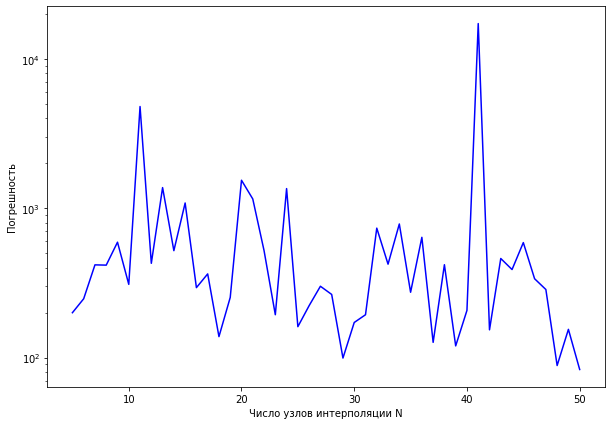

In [176]:
r=5
x0=100
x=[]
err=[]

for N in range(5, 51):
    xn=np.linspace(x0-r, x0+r, N)
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    er=np.abs(p(tn)-f(tn))
    err.append(np.max(er))
    x.append(N)

_, ax=plt.subplots(figsize=(10,7))
ax.semilogy(x, err, '-b')
ax.set_xlabel("Число узлов интерполяции N")
ax.set_ylabel("Погрешность")
plt.show()

$\textbf{Задание 11.}$

In [160]:
def Com(x,x0,N):
    p=1
    for i in range(1,N+1):
        k=x0+np.cos(np.pi*(2*i-1)/2/N)
        p=p*(x-k)
    return np.abs(p)
r=1
x0=10

$\textbf{N=5}$

In [161]:
def g5_10(x):
    return np.abs(192*np.cos(2*x)-64*x*np.sin(2*x))/mt.factorial(6)*Com(x,10,5)

xi=np.linspace(x0-r,x0+r,1000)
yi=g5_10(xi)
print(xi[np.argmax(yi)])
print(max(yi))

10.317317317317318
0.059494764922963225


In [162]:
def g5_100(x):
    return np.abs(192*np.cos(2*x)-64*x*np.sin(2*x))/mt.factorial(6)*Com(x,100,5)

xi=np.linspace(10*x0-r,10*x0+r,1000)
yi=g5_100(xi)
print(xi[np.argmax(yi)])
print(max(yi))

99.70070070070071
0.5494553270471546


In [163]:
def g5_1000(x):
    return np.abs(192*np.cos(2*x)-64*x*np.sin(2*x))/mt.factorial(6)*Com(x,1000,5)

xi=np.linspace(100*x0-r,100*x0+r,1000)
yi=g5_1000(xi)
print(xi[np.argmax(yi)])
print(max(yi))

999.7067067067067
5.409633863673166


In [164]:
r=1
N=5

for x0 in [10, 100, 1000]:
    xn=np.array([x0 + np.cos(np.pi*(2*i-1)/2/N) for i in range(1, N + 1)])
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    error=np.abs(f(tn)-p(tn))
    print("Экспериментальная погрешность для x0=",x0," - ",np.max(error))

Экспериментальная погрешность для x0= 10  -  0.12010792073531729
Экспериментальная погрешность для x0= 100  -  1.0445897361490637
Экспериментальная погрешность для x0= 1000  -  9.328841830479178


$\textbf{N=10}$

In [165]:
x0=10
def g10_10(x):
    return np.abs(-11364*np.sin(2*x)-2048*x*np.cos(2*x))/mt.factorial(11)*Com(x,10,10)

xi=np.linspace(x0-r,x0+r,1000)
yi=g10_10(xi)
print(xi[np.argmax(yi)])
print(max(yi))

9.69069069069069
1.118931313225934e-06


In [166]:
def g10_100(x):
    return np.abs(-11364*np.sin(2*x)-2048*x*np.cos(2*x))/mt.factorial(11)*Com(x,100,10)

xi=np.linspace(10*x0-r,10*x0+r,1000)
yi=g10_100(xi)
print(xi[np.argmax(yi)])
print(max(yi))

100.58758758758759
1.0077964166656779e-05


In [167]:
def g10_1000(x):
    return np.abs(-11364*np.sin(2*x)-2048*x*np.cos(2*x))/mt.factorial(11)*Com(x,1000,10)

xi=np.linspace(100*x0-r,100*x0+r,1000)
yi=g10_1000(xi)
print(xi[np.argmax(yi)])
print(max(yi))

1000.5875875875876
0.00010023749843996489


In [168]:
r=1
N=10

for x0 in [10, 100, 1000]:
    xn=np.array([x0 + np.cos(np.pi*(2*i-1)/2/N) for i in range(1, N + 1)])
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    error=np.abs(f(tn)-p(tn))
    print("Экспериментальная погрешность для x0=",x0," - ",np.max(error))

Экспериментальная погрешность для x0= 10  -  4.5984287464495566e-06
Экспериментальная погрешность для x0= 100  -  0.19391606008737128
Экспериментальная погрешность для x0= 1000  -  60.238281305242936


$\textbf{N=15}$

In [170]:
x0=10
def g15_10(x):
    return np.abs(-245760*np.sin(2*x)-32768*x*np.cos(2*x))/mt.factorial(16)*Com(x,10,15)

xi=np.linspace(x0-r,x0+r,1000)
yi=g15_10(xi)
print(xi[np.argmax(yi)])
print(max(yi))

9.692692692692694
1.1622691443442386e-12


In [171]:
def g15_100(x):
    return np.abs(-245760*np.sin(2*x)-32768*x*np.cos(2*x))/mt.factorial(16)*Com(x,100,15)

xi=np.linspace(10*x0-r,10*x0+r,1000)
yi=g15_100(xi)
print(xi[np.argmax(yi)])
print(max(yi))

100.50150150150151
9.544765013090065e-12


In [172]:
def g15_1000(x):
    return np.abs(-245760*np.sin(2*x)-32768*x*np.cos(2*x))/mt.factorial(16)*Com(x,1000,15)

xi=np.linspace(100*x0-r,100*x0+r,1000)
yi=g15_1000(xi)
print(xi[np.argmax(yi)])
print(max(yi))

999.022022022022
9.547880264407469e-11


In [173]:
r=1
N=15

for x0 in [10, 100, 1000]:
    xn=np.array([x0 + np.cos(np.pi*(2*i-1)/2/N) for i in range(1, N + 1)])
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    error=np.abs(f(tn)-p(tn))
    print("Экспериментальная погрешность для x0=",x0," - ",np.max(error))

Экспериментальная погрешность для x0= 10  -  1.2844500112407786e-06
Экспериментальная погрешность для x0= 100  -  0.1292131406165371
Экспериментальная погрешность для x0= 1000  -  65.66506528887635


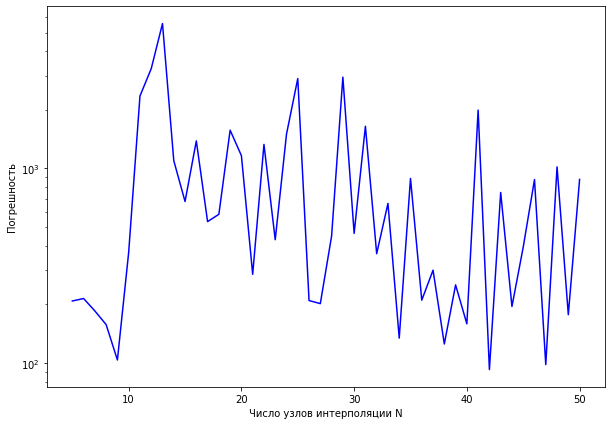

In [175]:
r=5
x0=100
x=[]
err=[]

for N in range(5, 51):
    xn=np.array([x0 + r*np.cos(np.pi*(2*i-1)/2/N) for i in range(1, N + 1)])
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    er=np.abs(p(tn)-f(tn))
    err.append(np.max(er))
    x.append(N)

_, ax=plt.subplots(figsize=(10,7))
ax.semilogy(x, err, '-b')
ax.set_xlabel("Число узлов интерполяции N")
ax.set_ylabel("Погрешность")
plt.show()

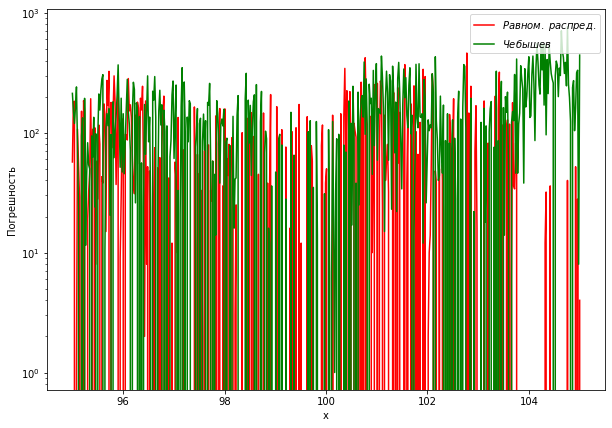

In [191]:
r=5
x0=100
N=15

xn=np.linspace(x0-r, x0+r, N)
Ch_xn=np.array([x0 + r*np.cos(np.pi*(2*i-1)/2/N) for i in range(1, N + 1)])
lin_p=interp_naive(xn, f(xn))
Ch_p=interp_naive(Ch_xn, f(Ch_xn))
x=np.linspace(x0-r, x0+r, 500)

_, ax=plt.subplots(figsize=(10,7))
ax.semilogy(x,lin_p(x), '-r')
ax.semilogy(x,Ch_p(x), '-g')
ax.set_xlabel("x")
ax.set_ylabel("Погрешность")
plt.legend(["$Равном.\;распред.$", "$Чебышев$"],loc=1)
plt.show()

$\textbf{Задание 13.}$ С поиском производной не все так просто: для $|x-1|$ есть скачок производной в нуле. Первая производная дает $sign(x-1)$, но вторая производная будет похожа на $\delta$-функцию. Поэтому с вычислением теор погрешности есть некоторые трудности. Посчитаем экспериментальную погрешность.

In [198]:
def h(x):
    return np.abs(x-1)
x0=1
r=1

N= 5
Экспериментальная погрешность для x0= 1  -  0.14720061072530066
Error 0.14720061072530066


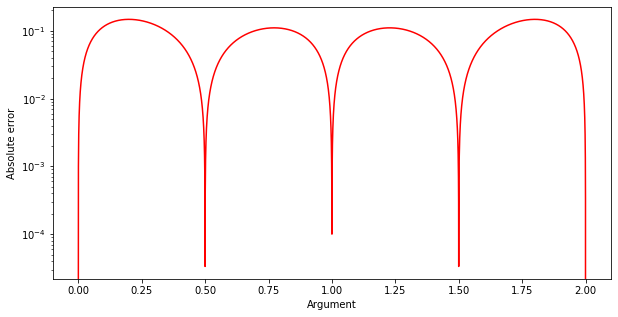

N= 10
Экспериментальная погрешность для x0= 1  -  0.07466808674855817
Error 0.07466808674855817


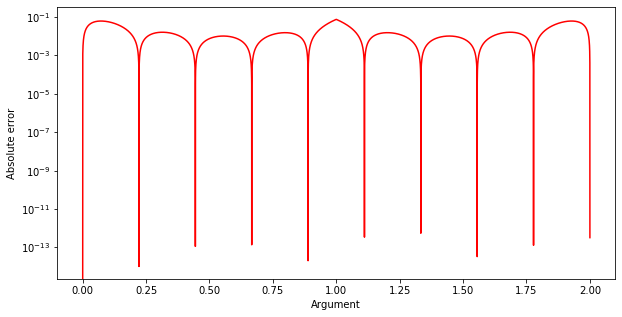

N= 15
Экспериментальная погрешность для x0= 1  -  4.062288694877257
Error 4.062288694877257


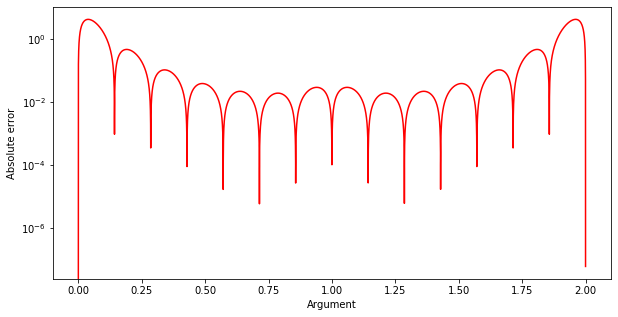

In [204]:
for N in [5, 10, 15]:
    xn=np.linspace(x0-r, x0+r, N)
    p=interp_naive(xn, h(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    err=np.abs(h(tn)-p(tn))
    
    print('N=',N)
    print("Экспериментальная погрешность для x0=",x0," - ",np.max(err))
    tn=np.linspace(x0-r, x0+r, 10000)
    error=np.abs(h(tn)-p(tn))
    print("Error", np.max(err))

    _, ax=plt.subplots(figsize=(10,5))
    ax.semilogy(tn, err,'-r')
    ax.set_xlabel("Argument")
    ax.set_ylabel("Absolute error")
    plt.show()

# Задания

14. Для функции из задания 9 постройте кубический сплайн дефекта 1 с узлами из задания 9. Можете воспользоваться функциями `scipy.interpolate.splrep` и `scipy.interpolate.splev` или реализовать свои аналоги.

15. Изучите зависимость погрешности приближения функции сплайном от числа узлов интерполяции. Сравните с результатом из задания 10. Когда погрешности совпадут?

16. Как можно обобщить изученные методы интерполяции на кривые в многомерном пространстве? 

17. Как можно интерполировать функции нескольких переменных?

18. Какие еще способы интерполяции существуют?


# Решение

$\textbf{Задание 14.}$

Экспериментальная погрешность для x0= 10  -  0.2813806043854927


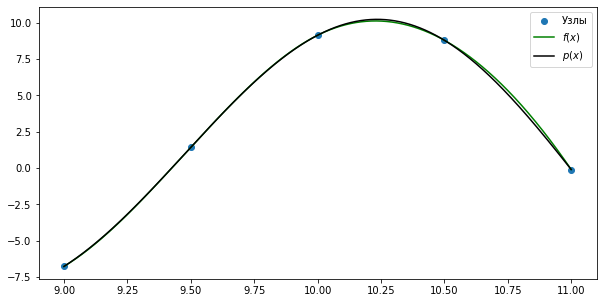

Экспериментальная погрешность для x0= 10  -  0.007123636639988495


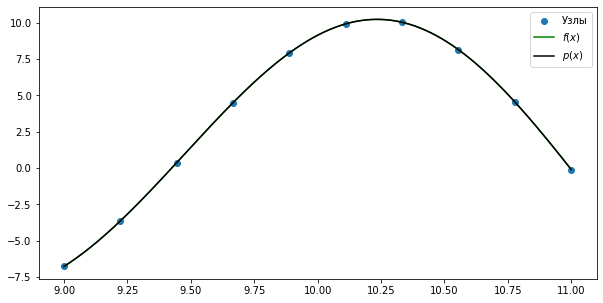

Экспериментальная погрешность для x0= 10  -  0.0012263129837837283


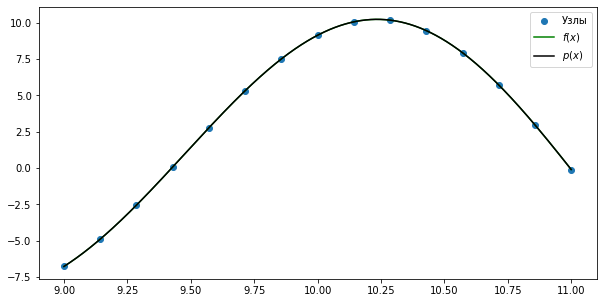

Экспериментальная погрешность для x0= 100  -  2.46282902688219


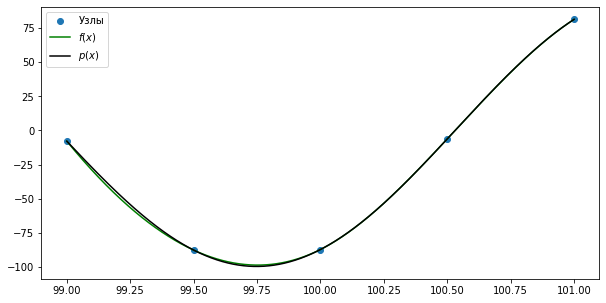

Экспериментальная погрешность для x0= 100  -  0.054049515958048744


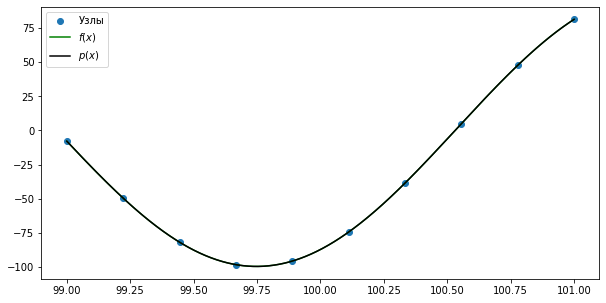

Экспериментальная погрешность для x0= 100  -  0.011084498489367434


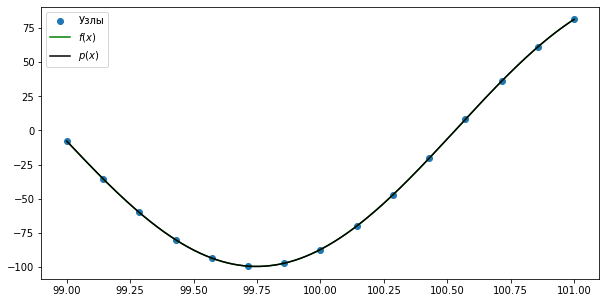

Экспериментальная погрешность для x0= 1000  -  22.820975596823416


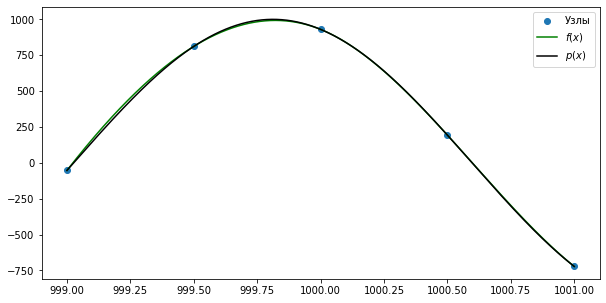

Экспериментальная погрешность для x0= 1000  -  0.431797629497936


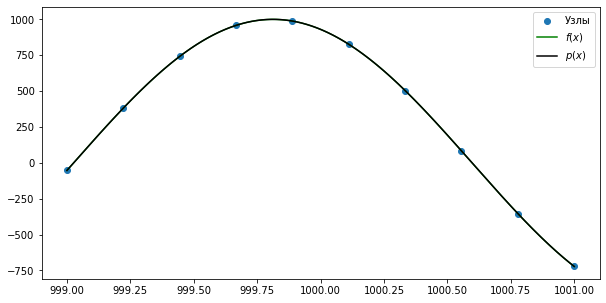

Экспериментальная погрешность для x0= 1000  -  0.09176970635041926


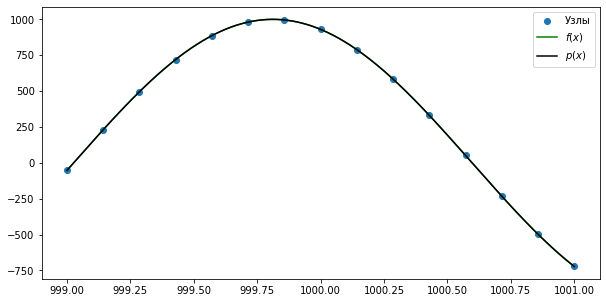

In [212]:
def f(x):
    return x*np.sin(2*x)
r=1
x0=[10, 100, 1000]  
N=[5, 10, 15]

for x in x0:
    for n in N:
        xn=np.linspace(x-r, x+r, n)
        yn=f(xn)
        splint=scipy.interpolate.splrep(xn, yn)
        tn=np.linspace(x-r, x+r, 10000)
        y=scipy.interpolate.splev(tn, splint)
        err=np.abs(f(tn) - y)
        print("Экспериментальная погрешность для x0=",x," - ",np.max(err))
        
        _, ax=plt.subplots(figsize=(10,5))
        ax.plot(xn, yn, 'o', tn, y, '-g')
        ax.plot(tn, f(tn), '-k')
        ax.legend(["Узлы","$f(x)$", "$p(x)$"])
        plt.show()

$\textbf{Задание 15.}$

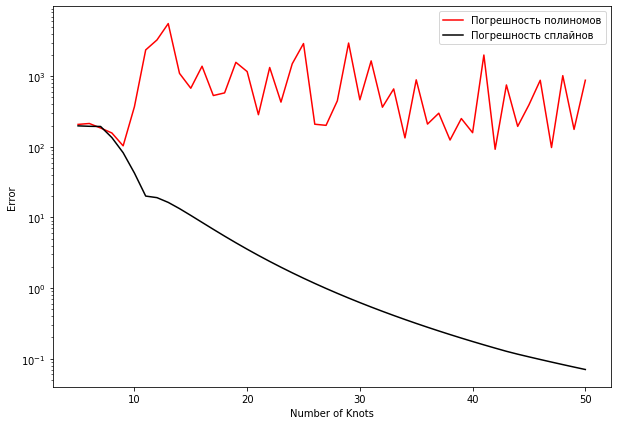

In [219]:
r=5
x0=100
x=[]
err_spl=[]
err_pol=[]

for N in range(5, 51): #вычисление ошибки интерполяции полиномами
    xn=np.array([x0 + r*np.cos(np.pi*(2*i-1)/2/N) for i in range(1, N + 1)])
    p=interp_naive(xn, f(xn))
    tn=np.linspace(x0-r, x0+r, 10000)
    err=np.abs(f(tn)-p(tn))
    err_pol.append(np.max(err))

for N in range(5, 51): #сплайны
    xn=np.linspace(x0-r, x0+r, N)
    yn=f(xn)
    splint=scipy.interpolate.splrep(xn, yn)
    tn=np.linspace(x0-r, x0+r, 10000)
    y=scipy.interpolate.splev(tn, splint)
    err=np.abs(f(tn)-y)
    err_spl.append(np.max(err))
    x.append(N)
    
_, ax=plt.subplots(figsize=(10,7))
ax.semilogy(x, err_pol, '-r')
ax.semilogy(x, err_spl, '-k') 
ax.set_xlabel("Number of Knots")
ax.set_ylabel("Error")
ax.legend(["Погрешность полиномов", "Погрешность сплайнов"])
plt.show()

Погрешности совпадают в начале графика, когда количество узлов интерполяции мало и нет особой разницы между интерполяцией сплайнами и полиномами.

$\textbf{Задание 16.}$ Интерполяция может происходить по точкам в n-мерном пространстве. Один из примеров: трилинейная интерполяция.

$\textbf{Задание 17.}$ Билинейная интерполяция, интерполяция многочленами Лагранжа

$\textbf{Задание 18.}$
Линейная интерполяция, рациональная интерполяция, эрмитова интерполяция, интерполяция формулами Ньютона, метод конечных разностей.